<a href="https://colab.research.google.com/github/aspyridakos/Speechbrain-MOABB-EEG-Processing/blob/main/COMP_432_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG-Based Motor Imagery Decoding with Deep Learning

```
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```

Mount to Google Drive to save results

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create working directory in drive

In [13]:
!mkdir '/content/drive/MyDrive/COMP432'
!mkdir '/content/drive/MyDrive/COMP432/replica' # folder for replicated experiment
!mkdir '/content/drive/MyDrive/COMP432/custom' # folder for custom experiment

mkdir: cannot create directory ‘/content/drive/MyDrive/COMP432’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/COMP432/replica’: File exists


## Part 1
Initial experiment using EEGNET.

In [12]:
%%capture stdout_stderr
%cd /content/drive/MyDrive/COMP432/

!pip install braindecode
!pip install tensorflow

Initializing SpeechBrain-MOABB

In [ ]:
%%capture
%cd /content/drive/MyDrive/COMP432/
!git clone https://github.com/speechbrain/benchmarks
%cd /content/drive/MyDrive/COMP432/benchmarks
!git checkout eeg

%cd /content/drive/MyDrive/COMP432/benchmarks/benchmarks/MOABB
!pip install -r extra-requirements.txt # Install additional dependencies

In [ ]:
%%capture
%cd /content/drive/MyDrive/COMP432/
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/drive/MyDrive/COMP432/speechbrain/

# Install required dependencies
!pip install -r requirements.txt

# Install in edit mode
!pip install -e .

%cd /content/drive/MyDrive/COMP432/

Define `yaml` file containing the hyper-params for the decoding pipeline using dataset BCNI2014_001 from MOABB.

In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

exammple_hyperparams = """
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.13 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 46.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 10 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 862 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.0001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.01742 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 19.1 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 61 # @orion_step1: --cnn_temporal_kernels~"uniform(4, 64,discrete=True)"
cnn_temporal_kernelsize: 51 # @orion_step1: --cnn_temporal_kernelsize~"uniform(24, 62,discrete=True)"
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 4 # @orion_step1: --cnn_spatial_depth_multiplier~"uniform(1, 4,discrete=True)"
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 7 # @orion_step1: --cnn_septemporal_point_kernels_ratio_~"uniform(0, 8, discrete=True)"
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 15 # @orion_step1: --cnn_septemporal_kernelsize_~"uniform(3, 24,discrete=True)"
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 7 # @orion_step1: --cnn_septemporal_pool~"uniform(1, 8,discrete=True)"
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.008464 # @orion_step1: --dropout~"uniform(0.0, 0.5)"
activation_type: 'elu'

model: !new:models.EEGNet.EEGNet
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>
"""

Save the `yaml` file on disk

In [ ]:
f = open('/content/drive/MyDrive/COMP432/example_hyperparams.yaml', 'w')
f.write(exammple_hyperparams)
f.close()

Train the neural network on a single cross-validation fold

In [ ]:
%cd /content/drive/MyDrive/COMP432/benchmarks/benchmarks/MOABB/

!python train.py /content/drive/MyDrive/COMP432/example_hyperparams.yaml \
--data_folder '/content/drive/MyDrive/COMP432/data/BNCI2014001' \
--cached_data_folder '/content/drive/MyDrive/COMP432/data' \
--output_folder '/content/drive/MyDrive/COMP432/results/single-fold-example/BNCI2014001' \
--data_iterator_name 'leave-one-session-out' \
--target_subject_idx 0 \
--target_session_idx 1 \
--number_of_epochs 50
# --number_of_epochs 50 \
#--device 'cpu' # Switch to cuda for a speed up, remove this line to run everything on GPU

Run a complete experiment by looping over the entire dataset.

In [ ]:
%cd /content/drive/MyDrive/COMP432/benchmarks/benchmarks/MOABB/
!chmod +x /content/drive/MyDrive/COMP432/benchmarks/benchmarks/MOABB/run_experiments.sh

!./run_experiments.sh --hparams /content/drive/MyDrive/COMP432/example_hyperparams.yaml \
--data_folder '/content/drive/MyDrive/COMP432/data/BNCI2014001' \
--cached_data_folder '/content/drive/MyDrive/COMP432/data' \
--output_folder '/content/drive/MyDrive/COMP432/results/full-experiment/BNCI2014001' \
--nsbj 9 --nsess 2 --nruns 1 --train_mode 'leave-one-session-out' \
--number_of_epochs 50

Streaming output truncated to the last 5000 lines.
 [4 2 8 0]
 [1 4 5 4]]
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in /content/drive/MyDrive/COMP432/results/full-experiment/BNCI2014001/run1/3712/leave-one-session-out/sub-006/0train/save/CKPT+2024-04-04+19-41-33+00
speechbrain.utils.checkpoints - Loading a checkpoint from /content/drive/MyDrive/COMP432/results/full-experiment/BNCI2014001/run1/3712/leave-one-session-out/sub-006/0train/save/CKPT+2024-04-04+19-41-33+00
speechbrain.utils.train_logger - epoch loaded: 50 - test loss: 1.08, test f1: 5.62e-01, test acc: 5.66e-01, test cm: [[34 11 14 13]
 [ 8 36 18 10]
 [ 7  6 52  7]
 [17  9  5 41]]
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in /content/drive/MyDrive/COMP432/results/full-experiment/BNCI2014001/run1/3712/leave-one-session-out/sub-006/0train/save/CKPT+2024-04-04+19-41-35+00
speechbrain.utils.checkpoints - Deleted checkpoint in /content/drive/MyDrive/COMP432/results/full-experiment/BNCI

# Results replication

Install MOABB, braindecode and skorch using `pip`

In [14]:
%%capture
!pip install moabb
!pip install braindecode
!pip install skorch

Define pipelines, dataset, and eval schemes

In [15]:
import warnings
import moabb
import mne
import os
import numpy as np
from scipy.stats import sem
from moabb.pipelines.utils import create_pipeline_from_config
import yaml
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery
import pickle

mne.set_log_level("CRITICAL")
moabb.set_log_level("info")
warnings.filterwarnings("ignore");

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [16]:
from collections import Counter
from functools import partial
from inspect import getmembers, isclass, isroutine

import mne
from braindecode.datasets.base import BaseConcatDataset
from braindecode.datasets.xy import create_from_X_y
from numpy import unique
from sklearn.base import BaseEstimator, TransformerMixin
from skorch.callbacks import Callback
from torch.nn import Module

class BraindecodeDatasetLoaderArray(BaseEstimator, TransformerMixin):
    def __init__(self, sfreq, ch_names=None, drop_last_window=False, kw_args=None):
        self.sfreq = sfreq
        self.ch_names = ch_names
        self.drop_last_window = drop_last_window
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.y = y
        return self

    def transform(self, X, y=None):
        if y is None:
            y = self.y
        dataset = create_from_X_y(
            X=X,
            y=y,
            window_size_samples=X.shape[2],
            window_stride_samples=X.shape[2],
            drop_last_window=self.drop_last_window,
            ch_names=self.ch_names,
            sfreq=self.sfreq,
        )

        return dataset

    def __sklearn_is_fitted__(self):
        """Return True since Transformer is stateless."""
        return True

In [17]:
import matplotlib.pyplot as plt
import mne
import seaborn as sns
import torch
from braindecode import EEGClassifier
from braindecode.models import EEGNetv4, EEGInception, ShallowFBCSPNet, Deep4Net
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery
from moabb.pipelines.features import Resampler_Epoch
from moabb.utils import setup_seed

mne.set_log_level(False)

# Print Information PyTorch
print(f"Torch Version: {torch.__version__}")

# Set up GPU if it is there
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
print("GPU is", "AVAILABLE" if cuda else "NOT AVAILABLE")

# Set random seed to be able to reproduce results
seed = 42
setup_seed(seed)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameter
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0
BATCH_SIZE = 64
SEED = 42
VERBOSE = 1
EPOCH = 1000
PATIENCE = 300

model = EEGNetv4(n_chans=22,n_outputs=4,n_times=4*125)
if device=='cuda':
    model = model.cuda()
clf = EEGClassifier(
    module=model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs=EPOCH,
    train_split=ValidSplit(0.2, random_state=seed),
    device=device,
    callbacks=[
        EarlyStopping(monitor="valid_loss", patience=PATIENCE),
        EpochScoring(
            scoring="accuracy", on_train=True, name="train_acc", lower_is_better=False
        ),
        EpochScoring(
            scoring="accuracy", on_train=False, name="valid_acc", lower_is_better=False
        ),

    ],
    verbose=0,  # Not printing the results for each epoch
)

pipes = {}
pipes["EEGNetV4"] = Pipeline([
    ('convert', moabb.pipelines.features.Convert_Epoch_Array()),
    ('scaler', moabb.pipelines.features.StandardScaler_Epoch()),
    ("Braindecode_dataset", BraindecodeDatasetLoaderArray(sfreq=125)),
     ("EEGNetv4", clf)])

dataset = BNCI2014_001()
paradigm = MotorImagery(n_classes=4, tmin=0, tmax=4, fmin=4, fmax=40, resample=125) # no resampling, using @250 Hz
evaluation = CrossSessionEvaluation(
    paradigm=paradigm,
    datasets=dataset,
    suffix="braindecode_example",
    hdf5_path='/content/drive/MyDrive/COMP432/replica',
    overwrite=True,
    return_epochs=True,
)

results_eegnet = evaluation.process(pipes)
results_eegnet.to_csv('/content/drive/MyDrive/COMP432/replica/benchmark_bnci2014001_network.csv', sep=',')

Torch Version: 2.2.1+cu121
GPU is AVAILABLE


BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat' to file '/root/mne_data/MNE-bnci-data/database/data-sets/001-2014/A01T.mat'.


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location



  0%|                                              | 0.00/42.8M [00:00<?, ?B/s]
  0%|                                     | 8.19k/42.8M [00:00<10:43, 66.6kB/s]
  0%|                                      | 32.8k/42.8M [00:00<05:01, 142kB/s]
  0%|                                      | 96.3k/42.8M [00:00<02:19, 305kB/s]
  0%|▏                                      | 201k/42.8M [00:00<01:23, 508kB/s]
  1%|▍                                      | 432k/42.8M [00:00<00:43, 980kB/s]
  2%|▊                                     | 881k/42.8M [00:00<00:22, 1.84MB/s]
  4%|█▌                                   | 1.78M/42.8M [00:00<00:11, 3.55MB/s]
  8%|███                                  | 3.58M/42.8M [00:01<00:05, 6.90MB/s]
 14%|█████▎                               | 6.13M/42.8M [00:01<00:03, 11.0MB/s]
 20%|███████▎                             | 8.46M/42.8M [00:01<00:02, 13.2MB/s]
 26%|█████████▍                           | 10.9M/42.8M [00:01<00:02, 15.1MB/s]
 31%|███████████▍                      

In [19]:
# ML pipelines with tuned hyper-parameters

tssvm_grid= """
name: Tangent Space SVM Grid

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1016/j.neucom.2012.12.039

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: TangentSpace
    from: pyriemann.tangentspace
    parameters:
      metric: "riemann"

  - name: SVC
    from: sklearn.svm
    parameters:
      kernel: "linear"

param_grid:
  svc__C:
    - 0.5
    - 1
    - 1.5
  svc__kernel:
    - "rbf"
    - "linear"
"""
f = open('/content/drive/MyDrive/COMP432/replica/tssvm_grid.yaml', "w")
f.write(tssvm_grid)
f.close()

# ML pipelines with fixed hyper-parameters
csp_lda = """
name: CSP + LDA

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1007/BF01129656
  - https://doi.org/10.1109/MSP.2008.4408441

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: CSP
    from: pyriemann.spatialfilters
    parameters:
      nfilter: 6

  - name: LinearDiscriminantAnalysis
    from: sklearn.discriminant_analysis
    parameters:
      solver: svd
"""

f = open('/content/drive/MyDrive/COMP432/replica/csp_lda.yaml', "w")
f.write(csp_lda)
f.close()

fcmdm= """
name: FgMDM

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1007/978-3-642-15995-4_78

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: FgMDM
    from: pyriemann.classification
    parameters:
      metric: "riemann"
"""
f = open('/content/drive/MyDrive/COMP432/replica/fcmdm.yaml', "w")
f.write(fcmdm)
f.close()

mdm="""
name: MDM

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1109/TBME.2011.2172210

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: MDM
    from: pyriemann.classification
    parameters:
      metric: "riemann"
"""
f = open('/content/drive/MyDrive/COMP432/replica/mdm.yaml', "w")
f.write(mdm)
f.close()

tslr="""
name: Tangent Space LR

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1016/j.neucom.2012.12.039

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: TangentSpace
    from: pyriemann.tangentspace
    parameters:
      metric: "riemann"

  - name: LogisticRegression
    from: sklearn.linear_model
    parameters:
      C: 1.0
"""
f = open('/content/drive/MyDrive/COMP432/replica/tslr.yaml', "w")
f.write(tslr)
f.close()

regcsp_shlda="""
name: DLCSPauto + shLDA

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1007/BF01129656
  - https://doi.org/10.1109/MSP.2008.4408441

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: CSP
    from: pyriemann.spatialfilters
    parameters:
      nfilter: 6

  - name: LinearDiscriminantAnalysis
    from: sklearn.discriminant_analysis
    parameters:
      solver: lsqr
      shrinkage: auto
"""
f = open('/content/drive/MyDrive/COMP432/replica/regcsp_shlda.yaml', "w")
f.write(regcsp_shlda)
f.close()

In [21]:
pipeline_fpaths = ['/content/drive/MyDrive/COMP432/replica/tssvm_grid.yaml',
                   '/content/drive/MyDrive/COMP432/replica/csp_lda.yaml',
                   '/content/drive/MyDrive/COMP432/replica/fcmdm.yaml',
                   '/content/drive/MyDrive/COMP432/replica/mdm.yaml',
                   '/content/drive/MyDrive/COMP432/replica/tslr.yaml',
                   '/content/drive/MyDrive/COMP432/replica/regcsp_shlda.yaml',]
pipeline_names = ['TS+SVM',
                  'CSP+LDA',
                  'FgMDM',
                  'MDM',
                  'TS+LR',
                  'regCSP+shLDA']
pipelines = {}
print('Building pipelines...')
for pipeline_name, pipeline_fpath in zip(pipeline_names, pipeline_fpaths):
    #ppl = os.path.split(pipeline_fpath)[1].split('.yaml')[0]
    with open(pipeline_fpath) as f:
        pipeline = yaml.safe_load(f)
    print('Including {0} pipeline'.format(pipeline_name))
    pipelines[pipeline_name] = create_pipeline_from_config(pipeline['pipeline'])


Building pipelines...
Including TS+SVM pipeline
Including CSP+LDA pipeline
Including FgMDM pipeline
Including MDM pipeline
Including TS+LR pipeline
Including regCSP+shLDA pipeline


In [22]:
datasets = [BNCI2014_001()]
paradigm = MotorImagery(n_classes=4, resample=125, tmin=0, tmax=4, fmin=4, fmax=40, )
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets,
    hdf5_path='/content/drive/MyDrive/COMP432/replica',
    overwrite=True
)

results = evaluation.process(pipelines)
results.to_csv('/content/drive/MyDrive/COMP432/replica/benchmark_bnci2014001_ml.csv', sep=',')

BNCI2014-001-CrossSession: 100%|██████████| 9/9 [02:00<00:00, 13.37s/it]


In [23]:
import pandas as pd
results_ml = pd.read_csv('/content/drive/MyDrive/COMP432/replica/benchmark_bnci2014001_ml.csv', sep=',')
results_network = pd.read_csv('/content/drive/MyDrive/COMP432/replica/benchmark_bnci2014001_network.csv', sep=',')

results = pd.concat([results_ml, results_network]).reset_index(drop=True)
results.to_csv('/content/drive/MyDrive/COMP432/replica/benchmark_bnci2014001.csv', sep=',')

Extracting test set results and saving as dict

In [24]:
pipeline_names = list(pipelines.keys())
pipeline_names = sorted(pipeline_names)
pipeline_names += ['EEGNetV4']
print('Results on: \n-dataset: {0};\n-cross-session evaluation scheme;\n-score function: {1}.'.format(datasets[0].code, paradigm.scoring))
print('#'*10)
results_moabb = {}
for pipeline_name in pipeline_names:
    idx_pipeline = np.where(results['pipeline'].values==pipeline_name)[0]
    scores = results['score'].values[idx_pipeline]
    print('{0}: {1} (mean value); {2} (standard error of the mean)'.format(pipeline_name,
                                                                           round(np.mean(scores).item(),4),
                                                                           round(sem(scores).item(), 4)))
    results_moabb[pipeline_name] = results['score'][idx_pipeline].values.reshape(
        np.unique(results['subject']).shape[0],
        np.unique(results['session']).shape[0])
with open('/content/drive/MyDrive/COMP432/replica/results_moabb.pkl', 'wb') as handle:
    pickle.dump(results_moabb, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('#'*10)

Results on: 
-dataset: BNCI2014-001;
-cross-session evaluation scheme;
-score function: accuracy.
##########
CSP+LDA: 0.5432 (mean value); 0.0394 (standard error of the mean)
FgMDM: 0.6202 (mean value); 0.0297 (standard error of the mean)
MDM: 0.5179 (mean value); 0.0316 (standard error of the mean)
TS+LR: 0.6341 (mean value); 0.0316 (standard error of the mean)
TS+SVM: 0.619 (mean value); 0.029 (standard error of the mean)
regCSP+shLDA: 0.5586 (mean value); 0.0362 (standard error of the mean)
EEGNetV4: 0.5324 (mean value); 0.0414 (standard error of the mean)
##########


Download and unzip SpeechBrain-MOABB results

In [32]:
# Downloading Speechbrain-MOABB results using the Dropbox file provided in the Speechbrain-MOABB repository
url="https://www.dropbox.com/sh/ux0i0suljojonmb/AABsTBpEKCTmVE784yQw-WGMa?dl=1"
!wget -O /content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb.zip $url

--2024-04-09 19:03:08--  https://www.dropbox.com/sh/ux0i0suljojonmb/AABsTBpEKCTmVE784yQw-WGMa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/dl/ux0i0suljojonmb/AABsTBpEKCTmVE784yQw-WGMa [following]
--2024-04-09 19:03:09--  https://www.dropbox.com/sh/dl/ux0i0suljojonmb/AABsTBpEKCTmVE784yQw-WGMa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4ac0692a3c602c0ca90677af3a.dl.dropboxusercontent.com/zip_download_get/B0HTwYB1zKm-DuKlg1ysYGZ8JoxcOHuRWIInrahOpKt2HF3tIjA0TBq8sx-cSlVuFZv6mb-xjK3BE30muVvjuEDUkC5AZ7z93if2eWq1Q_6LHA?dl=1# [following]
--2024-04-09 19:03:09--  https://uc4ac0692a3c602c0ca90677af3a.dl.dropboxusercontent.com/zip_download_get/B0HTwYB1zKm-DuKlg1ysYGZ8JoxcOHuRWIInrahOpKt2HF3tIjA0TBq8sx-cSlVuFZv6mb-xjK3BE30muVvjuEDU

In [33]:
# unzipping Speechbrain-MOABB results (specifically for BNCI2014-001)
!unzip -j /content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb.zip results_BNCI2014001.tar.gz -d /content/drive/MyDrive/COMP432/replica
!mkdir /content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb
!tar -xvzf results_BNCI2014001.tar.gz -C /content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb

Archive:  /content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb.zip
 extracting: /content/drive/MyDrive/COMP432/replica/results_BNCI2014001.tar.gz  
tar (child): results_BNCI2014001.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


Extracting test set results and saving as dict

In [ ]:
import glob
import pickle
import os
import numpy as np


model_fnames = ['EEGNet', 'ShallowConvNet', 'EEGConformer']
results_speechbrain_moabb_folder = '/content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb'
def get_results_single_run(run_folder):
    seed_dir = glob.glob(os.path.join(run_folder, '*/'))[0]
    sbj_dirs = glob.glob(os.path.join(seed_dir, 'leave-one-session-out', '*/'))
    sbj_dirs = sorted(sbj_dirs)
    m = []
    for sbj_dir in sbj_dirs:
        sess_dirs = glob.glob(os.path.join(sbj_dir, '*/'))
        mm = []
        for sess_dir in sess_dirs:
            with open(os.path.join(sess_dir, 'test_metrics.pkl'), 'rb') as f:
                data = pickle.load(f)
            mm.append(np.array(data['acc']))
        m.append(mm)
    m = np.array(m)
    return m
results = {}
for model_fname in model_fnames:
    final_evaluation_folder = os.path.join(results_speechbrain_moabb_folder,
                                           'BNCI2014001',
                                           model_fname,
                                           'hopt',
                                           'best',)
    final_evaluation_folder = glob.glob(os.path.join(final_evaluation_folder, '*/'))
    final_evaluation_folder = sorted(final_evaluation_folder)
    final_evaluation_folder = final_evaluation_folder[0]
    print(final_evaluation_folder)

    tmp_results = []
    for run in np.arange(10):
        run_folder = os.path.join(final_evaluation_folder, 'run{0}'.format(run+1))
        tmp_results.append(get_results_single_run(run_folder))
    tmp_results = np.array(tmp_results)
    print(tmp_results.shape)
    results[model_fname] = tmp_results
with open('/content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

/content/drive/MyDrive/COMP432/results_speechbrain_moabb/BNCI2014001/EEGNet/hopt/best/VVuxlb/
(10, 9, 2)
/content/drive/MyDrive/COMP432/results_speechbrain_moabb/BNCI2014001/ShallowConvNet/hopt/best/wXubfc/
(10, 9, 2)
/content/drive/MyDrive/COMP432/results_speechbrain_moabb/BNCI2014001/EEGConformer/hopt/best/auTEkH/
(10, 9, 2)


Replicate the statistical analysis (SpeechBrain-MOABB vs. MOABB vs. MOABB+braindecode pipelines) and the figure of the paper

EEGNet vs. CSP+LDA: difference=0.18834876475308635
EEGNet vs. regCSP+shLDA: difference=0.1729166641975308
EEGNet vs. MDM: difference=0.21361882586419748
EEGNet vs. FgMDM: difference=0.11138118086419747
EEGNet vs. TS+LR: difference=0.09749228253086414
EEGNet vs. TS+SVM: difference=0.11253858086419749
EEGNet vs. EEGNetV4: difference=0.19934414864197525
EEGNet vs. ShallowConvNet: difference=0.035763888888888845
EEGNet vs. EEGConformer: difference=0.055748456790123385
[0, 1, 2, 3, 4, 5, 6, 8, 9]
Uncorrected p-values: [0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.0390625, 0.0390625]
Corrected p-values for multiple tests: [0.00502232 0.00502232 0.00502232 0.00502232 0.00502232 0.00502232
 0.00502232 0.0390625  0.0390625 ]


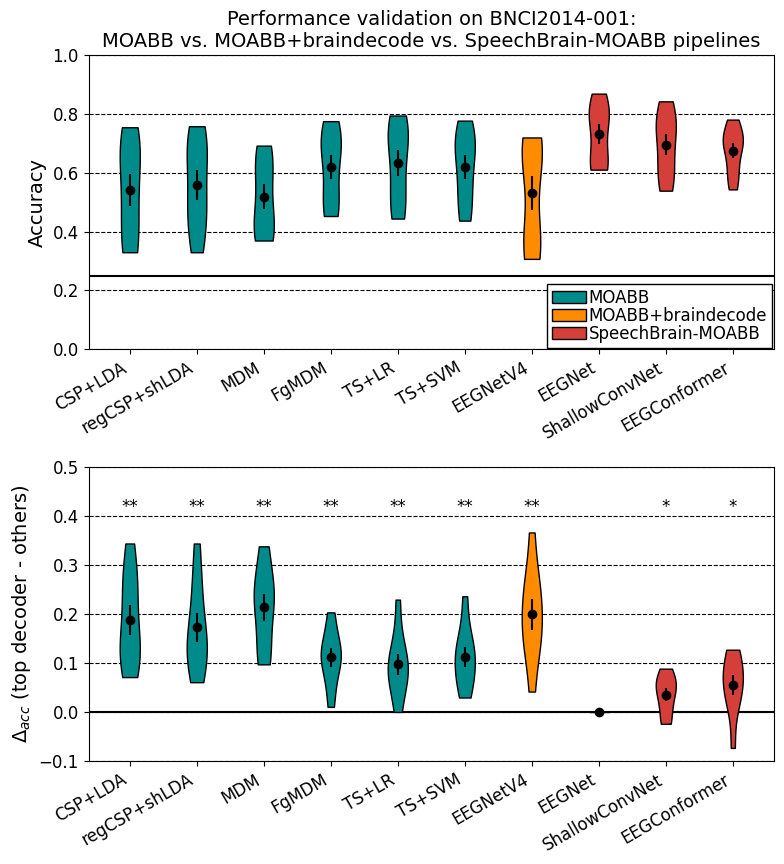

In [ ]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import wilcoxon, sem
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14#16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

with open('/content/drive/MyDrive/COMP432/replica/results_moabb.pkl', 'rb') as f:
    results_moabb = pickle.load(f)
with open('/content/drive/MyDrive/COMP432/replica/results_speechbrain_moabb.pkl', 'rb') as f:
    results_speechbrain_moabb = pickle.load(f)
scores = []

target_keys_moabb = ['CSP+LDA', 'regCSP+shLDA', 'MDM', 'FgMDM', 'TS+LR', 'TS+SVM', 'EEGNetV4']
for key in target_keys_moabb:
    scores.append(np.mean(results_moabb[key], axis=-1))
for key in results_speechbrain_moabb.keys():
    scores.append(np.mean(results_speechbrain_moabb[key], axis=(0,-1)))

means = [np.mean(s) for s in scores]
sems = [sem(s) for s in scores]
keys = target_keys_moabb + list(results_speechbrain_moabb.keys())

fig, axs = plt.subplots(2,1, figsize=(8,11/1.25))
ax = axs[0]
vp = ax.violinplot(dataset=scores, widths=0.3,
                   showmeans=False, showmedians=False, showextrema=False,
                   )
for pc in vp['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][:len(target_keys_moabb)]:
    pc.set_facecolor('darkcyan')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][len(target_keys_moabb)-1:len(target_keys_moabb)]:
    pc.set_facecolor('darkorange')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
ax.errorbar(np.arange(len(keys))+1, means, sems, linestyle='none', marker='o',
            c='k', zorder=3)

ax.set_ylim(0., 1)
ax.axhline(y=0.25, c='k')
ax.grid(axis='y', c='k', linestyle='--', zorder=1)
ax.set_title('Performance validation on BNCI2014-001:\nMOABB vs. MOABB+braindecode vs. SpeechBrain-MOABB pipelines')
ax.set_xticks(np.arange(len(keys))+1)
ax.set_xticklabels(keys, rotation=30, ha='right')
ax.set_ylabel('Accuracy')
legend_elements = [
    Patch(facecolor='darkcyan', edgecolor='k', alpha=1, label='MOABB', hatch=""),
    Patch(facecolor='darkorange', edgecolor='k', alpha=1, label='MOABB+braindecode', hatch=""),
    Patch(facecolor='#D43F3A', edgecolor='k', alpha=1, label='SpeechBrain-MOABB', hatch=""),
]
leg = ax.legend(handles=legend_elements,
                  handlelength=2,
                  handletextpad=0.2,
                  labelspacing=0,
                  borderpad=0.3,
                  borderaxespad=0.1,
                  columnspacing=0.5,
                  ncols=1,
                  loc="lower right",
                  framealpha=1,
                  edgecolor="k",
                  ncol=1,
                  )

leg.get_frame().set_boxstyle('Round', pad=0., rounding_size=0)


ax = axs[1]
model_fname = 'EEGNet'
idx0 = [i for i,k in enumerate(keys) if k==model_fname][0]
diff_scores = [scores[idx0]-s for s in scores]
means = [np.mean(s) for s in diff_scores]
sems = [sem(s) for s in diff_scores]
vp = ax.violinplot(dataset=diff_scores, widths=0.3,
                   showmeans=False, showmedians=False, showextrema=False,
                   )

for pc in vp['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][:len(target_keys_moabb)]:
    pc.set_facecolor('darkcyan')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][len(target_keys_moabb)-1:len(target_keys_moabb)]:
    pc.set_facecolor('darkorange')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
idx = np.arange(len(keys))
idx = np.setdiff1d(idx, [idx0])

x = np.arange(len(keys))+1
ax.errorbar(x, np.array(means), np.array(sems), linestyle='none', marker='o',
            c='k', zorder=3)
ax.set_ylim(-0.1, 0.5)
ax.axhline(y=0., c='k')
ax.grid(axis='y', c='k', linestyle='--', zorder=1)
ax.set_xticks(np.arange(len(keys))+1)
ax.set_xticklabels(keys, rotation=30,ha='right')
ax.set_ylabel(r'$\Delta_{acc}$ (top decoder - others)')

d0 = np.mean(results_speechbrain_moabb[model_fname], axis=(0, -1)) # (9,)
pvals = []
conds = []
for pipeline_fname in target_keys_moabb:
    d1 = np.mean(results_moabb[pipeline_fname], axis=-1) # (9,)
    idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
    print('{0} vs. {1}: difference={2}'.format(model_fname, pipeline_fname, np.mean(d0-d1)))
    _, p = wilcoxon(d0, d1)
    pvals.append(p)
    conds.append(idx1)
for pipeline_fname in results_speechbrain_moabb.keys():
    d1 = np.mean(results_speechbrain_moabb[pipeline_fname], axis=(0,-1)) # (9,)
    idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
    if d0.mean()!=d1.mean():
        print('{0} vs. {1}: difference={2}'.format(model_fname, pipeline_fname, np.mean(d0-d1)))
        _, p = wilcoxon(d0, d1)
        pvals.append(p)
        conds.append(idx1)

print(conds)
print("Uncorrected p-values: {0}".format(pvals))
_, pvals, _, _ = multipletests(pvals, method='fdr_bh')
print("Corrected p-values for multiple tests: {0}".format(pvals))
signs = []
for p in pvals:
    if p<0.001:
        signs.append('***')
    else:
        if p<0.01:
            signs.append('**')
        else:
            if p<0.05:
                signs.append('*')
            else:
                signs.append('')
for k, sign in zip(conds, signs):
    ax.text(x=k+1, y=.4, s=sign, ha='center', va='bottom', fontsize=12)

fig.tight_layout()
fig.savefig('fig4.pdf', format='PDF', dpi=600)

In [ ]:
# Check for statistical significance vs. MOABB and MOABB+braindecode for each random initialization of EEGNet SpeechBrain-MOABB (not only for the average across seeds)
for i in np.arange(10):
    d0 = np.mean(results_speechbrain_moabb[model_fname][i,...], axis=(-1, )) # (9,)
    pvals = []
    for pipeline_fname in target_keys_moabb:
        d1 = np.mean(results_moabb[pipeline_fname], axis=-1) # (9,)
        idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
        _, p = wilcoxon(d0, d1)
        pvals.append(p)
        conds.append(idx1)
    for pipeline_fname in results_speechbrain_moabb.keys():
        d1 = np.mean(results_speechbrain_moabb[pipeline_fname][i,...], axis=(-1, )) # (9,)
        idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
        if d0.mean()!=d1.mean():
            _, p = wilcoxon(d0, d1)
            pvals.append(p)
            conds.append(idx1)
    _, pvals, _, _ = multipletests(pvals, method='fdr_bh')
    #print("Corrected p-values for multiple tests: {0}".format(pvals))
    print("random iteration no. {0} always significant vs. MOABB / MOABB+braindecode?: {1} ({2} comparisons corrected for multiple tests)".format(
        i, np.all(pvals[:-2]<.05), pvals.shape[0])
    )

random iteration no. 0 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random iteration no. 1 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random iteration no. 2 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random iteration no. 3 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random iteration no. 4 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random iteration no. 5 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random iteration no. 6 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random iteration no. 7 always significant vs. MOABB / MOABB+braindecode?: True (9 comparisons corrected for multiple tests)
random i



---



# Custom model 1

In [5]:
!mkdir '/content/drive/MyDrive/custom_models/model_1'

mkdir: cannot create directory ‘/content/drive/MyDrive/custom_models/model_1’: No such file or directory


Install MOABB, braindecode and skorch using `pip`

In [ ]:
%%capture
!pip install moabb
!pip install braindecode
!pip install skorch

Define pipelines, dataset, and eval schemes

In [ ]:
import warnings
import moabb
import mne
import os
import numpy as np
from scipy.stats import sem
from moabb.pipelines.utils import create_pipeline_from_config
import yaml
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery
import pickle

mne.set_log_level("CRITICAL")
moabb.set_log_level("info")
warnings.filterwarnings("ignore");

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
C:\Users\aspyr\AppData\Local\Programs\Python\Python311\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [ ]:
from collections import Counter
from functools import partial
from inspect import getmembers, isclass, isroutine

import mne
from braindecode.datasets.base import BaseConcatDataset
from braindecode.datasets.xy import create_from_X_y
from numpy import unique
from sklearn.base import BaseEstimator, TransformerMixin
from skorch.callbacks import Callback
from torch.nn import Module

class BraindecodeDatasetLoaderArray(BaseEstimator, TransformerMixin):
    def __init__(self, sfreq, ch_names=None, drop_last_window=False, kw_args=None):
        self.sfreq = sfreq
        self.ch_names = ch_names
        self.drop_last_window = drop_last_window
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.y = y
        return self

    def transform(self, X, y=None):
        if y is None:
            y = self.y
        dataset = create_from_X_y(
            X=X,
            y=y,
            window_size_samples=X.shape[2],
            window_stride_samples=X.shape[2],
            drop_last_window=self.drop_last_window,
            ch_names=self.ch_names,
            sfreq=self.sfreq,
        )

        return dataset

    def __sklearn_is_fitted__(self):
        """Return True since Transformer is stateless."""
        return True

In [ ]:
import matplotlib.pyplot as plt
import mne
import seaborn as sns
import torch
from braindecode import EEGClassifier
from braindecode.models import EEGNetv4, EEGInception, ShallowFBCSPNet, Deep4Net
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery
from moabb.pipelines.features import Resampler_Epoch
from moabb.utils import setup_seed

mne.set_log_level(False)

# Print Information PyTorch
print(f"Torch Version: {torch.__version__}")

# Set up GPU if it is there
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
print("GPU is", "AVAILABLE" if cuda else "NOT AVAILABLE")

# Set random seed to be able to reproduce results
seed = 42
setup_seed(seed)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameter
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0
BATCH_SIZE = 64
SEED = 42
VERBOSE = 1
EPOCH = 1000
PATIENCE = 300

model = EEGNetv4(n_chans=22,n_outputs=4,n_times=4*125)
if device=='cuda':
    model = model.cuda()
clf = EEGClassifier(
    module=model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs=EPOCH,
    train_split=ValidSplit(0.2, random_state=seed),
    device=device,
    callbacks=[
        EarlyStopping(monitor="valid_loss", patience=PATIENCE),
        EpochScoring(
            scoring="accuracy", on_train=True, name="train_acc", lower_is_better=False
        ),
        EpochScoring(
            scoring="accuracy", on_train=False, name="valid_acc", lower_is_better=False
        ),

    ],
    verbose=0,  # Not printing the results for each epoch
)

pipes = {}
pipes["EEGNetV4"] = Pipeline([
    ('convert', moabb.pipelines.features.Convert_Epoch_Array()),
    ('scaler', moabb.pipelines.features.StandardScaler_Epoch()),
    ("Braindecode_dataset", BraindecodeDatasetLoaderArray(sfreq=125)),
     ("EEGNetv4", clf)])

dataset = BNCI2014_001()
paradigm = MotorImagery(n_classes=4, tmin=0, tmax=4, fmin=4, fmax=40, resample=125) # no resampling, using @250 Hz
evaluation = CrossSessionEvaluation(
    paradigm=paradigm,
    datasets=dataset,
    suffix="braindecode_example",
    hdf5_path='/content/drive/MyDrive/custom_models/model_1',
    overwrite=True,
    return_epochs=True,
)

results_eegnet = evaluation.process(pipes)
results_eegnet.to_csv('/content/drive/MyDrive/custom_models/model_1/benchmark_bnci2014001_network.csv', sep=',')

2024-04-05 00:49:17,219 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


Torch Version: 2.2.0+cpu
GPU is NOT AVAILABLE


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'G:\\content'

In [ ]:
# ML pipelines with tuned hyper-parameters

tssvm_grid= """
name: Tangent Space SVM Grid

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1016/j.neucom.2012.12.039

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: TangentSpace
    from: pyriemann.tangentspace
    parameters:
      metric: "riemann"

  - name: SVC
    from: sklearn.svm
    parameters:
      kernel: "linear"

param_grid:
  svc__C:
    - 0.5
    - 1
    - 1.5
  svc__kernel:
    - "rbf"
    - "linear"
"""
f = open('/content/drive/MyDrive/COMP432/tssvm_grid.yaml', "w")
f.write(tssvm_grid)
f.close()

# ML pipelines with fixed hyper-parameters
csp_lda = """
name: CSP + LDA

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1007/BF01129656
  - https://doi.org/10.1109/MSP.2008.4408441

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: CSP
    from: pyriemann.spatialfilters
    parameters:
      nfilter: 6

  - name: LinearDiscriminantAnalysis
    from: sklearn.discriminant_analysis
    parameters:
      solver: svd
"""

f = open('/content/drive/MyDrive/COMP432/csp_lda.yaml', "w")
f.write(csp_lda)
f.close()

fcmdm= """
name: FgMDM

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1007/978-3-642-15995-4_78

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: FgMDM
    from: pyriemann.classification
    parameters:
      metric: "riemann"
"""
f = open('/content/drive/MyDrive/COMP432/fcmdm.yaml', "w")
f.write(fcmdm)
f.close()

mdm="""
name: MDM

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1109/TBME.2011.2172210

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: MDM
    from: pyriemann.classification
    parameters:
      metric: "riemann"
"""
f = open('/content/drive/MyDrive/COMP432/mdm.yaml', "w")
f.write(mdm)
f.close()

tslr="""
name: Tangent Space LR

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1016/j.neucom.2012.12.039

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: TangentSpace
    from: pyriemann.tangentspace
    parameters:
      metric: "riemann"

  - name: LogisticRegression
    from: sklearn.linear_model
    parameters:
      C: 1.0
"""
f = open('/content/drive/MyDrive/COMP432/tslr.yaml', "w")
f.write(tslr)
f.close()

regcsp_shlda="""
name: DLCSPauto + shLDA

paradigms:
  - LeftRightImagery
  - MotorImagery

citations:
  - https://doi.org/10.1007/BF01129656
  - https://doi.org/10.1109/MSP.2008.4408441

pipeline:
  - name: Covariances
    from: pyriemann.estimation
    parameters:
      estimator: oas

  - name: CSP
    from: pyriemann.spatialfilters
    parameters:
      nfilter: 6

  - name: LinearDiscriminantAnalysis
    from: sklearn.discriminant_analysis
    parameters:
      solver: lsqr
      shrinkage: auto
"""
f = open('/content/drive/MyDrive/COMP432/regcsp_shlda.yaml', "w")
f.write(regcsp_shlda)
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/COMP432/tssvm_grid.yaml'

In [ ]:
pipeline_fpaths = ['/content/drive/MyDrive/COMP432/tssvm_grid.yaml',
                   '/content/drive/MyDrive/COMP432/csp_lda.yaml',
                   '/content/drive/MyDrive/COMP432/fcmdm.yaml',
                   '/content/drive/MyDrive/COMP432/mdm.yaml',
                   '/content/drive/MyDrive/COMP432/tslr.yaml',
                   '/content/drive/MyDrive/COMP432/regcsp_shlda.yaml',]
pipeline_names = ['TS+SVM',
                  'CSP+LDA',
                  'FgMDM',
                  'MDM',
                  'TS+LR',
                  'regCSP+shLDA']
pipelines = {}
print('Building pipelines...')
for pipeline_name, pipeline_fpath in zip(pipeline_names, pipeline_fpaths):
    #ppl = os.path.split(pipeline_fpath)[1].split('.yaml')[0]
    with open(pipeline_fpath) as f:
        pipeline = yaml.safe_load(f)
    print('Including {0} pipeline'.format(pipeline_name))
    pipelines[pipeline_name] = create_pipeline_from_config(pipeline['pipeline'])


In [ ]:
datasets = [BNCI2014_001()]
paradigm = MotorImagery(n_classes=4, resample=125, tmin=0, tmax=4, fmin=4, fmax=40, )
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets,
    hdf5_path='/content/drive/MyDrive/COMP432',
    overwrite=True
)

results = evaluation.process(pipelines)
results.to_csv('/content/drive/MyDrive/COMP432/benchmark_bnci2014001_ml.csv', sep=',')

In [ ]:
import pandas as pd
results_ml = pd.read_csv('/content/drive/MyDrive/COMP432/benchmark_bnci2014001_ml.csv', sep=',')
results_network = pd.read_csv('/content/drive/MyDrive/COMP432/benchmark_bnci2014001_network.csv', sep=',')

results = pd.concat([results_ml, results_network]).reset_index(drop=True)
results.to_csv('/content/drive/MyDrive/COMP432/benchmark_bnci2014001.csv', sep=',')

Extracting test set results and saving as dict

In [ ]:
pipeline_names = list(pipelines.keys())
pipeline_names = sorted(pipeline_names)
pipeline_names += ['EEGNetV4']
print('Results on: \n-dataset: {0};\n-cross-session evaluation scheme;\n-score function: {1}.'.format(datasets[0].code, paradigm.scoring))
print('#'*10)
results_moabb = {}
for pipeline_name in pipeline_names:
    idx_pipeline = np.where(results['pipeline'].values==pipeline_name)[0]
    scores = results['score'].values[idx_pipeline]
    print('{0}: {1} (mean value); {2} (standard error of the mean)'.format(pipeline_name,
                                                                           round(np.mean(scores).item(),4),
                                                                           round(sem(scores).item(), 4)))
    results_moabb[pipeline_name] = results['score'][idx_pipeline].values.reshape(
        np.unique(results['subject']).shape[0],
        np.unique(results['session']).shape[0])
with open('/content/drive/MyDrive/COMP432/results_moabb.pkl', 'wb') as handle:
    pickle.dump(results_moabb, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('#'*10)

Download and unzip SpeechBrain-MOABB results

In [ ]:
# Downloading Speechbrain-MOABB results using the Dropbox file provided in the Speechbrain-MOABB repository
url="https://www.dropbox.com/sh/ux0i0suljojonmb/AABsTBpEKCTmVE784yQw-WGMa?dl=1"
!wget -O /content/drive/MyDrive/COMP432/results_speechbrain_moabb.zip $url

In [ ]:
# unzipping Speechbrain-MOABB results (specifically for BNCI2014-001)
!unzip -j /content/drive/MyDrive/COMP432/results_speechbrain_moabb.zip results_BNCI2014001.tar.gz -d /content/drive/MyDrive/COMP432
!mkdir /content/drive/MyDrive/COMP432/results_speechbrain_moabb
!tar -xvzf results_BNCI2014001.tar.gz -C /content/drive/MyDrive/COMP432/results_speechbrain_moabb

Extracting test set results and saving as dict

In [ ]:
import glob
import pickle
import os
import numpy as np


model_fnames = ['EEGNet', 'ShallowConvNet', 'EEGConformer']
results_speechbrain_moabb_folder = '/content/drive/MyDrive/COMP432/results_speechbrain_moabb'
def get_results_single_run(run_folder):
    seed_dir = glob.glob(os.path.join(run_folder, '*/'))[0]
    sbj_dirs = glob.glob(os.path.join(seed_dir, 'leave-one-session-out', '*/'))
    sbj_dirs = sorted(sbj_dirs)
    m = []
    for sbj_dir in sbj_dirs:
        sess_dirs = glob.glob(os.path.join(sbj_dir, '*/'))
        mm = []
        for sess_dir in sess_dirs:
            with open(os.path.join(sess_dir, 'test_metrics.pkl'), 'rb') as f:
                data = pickle.load(f)
            mm.append(np.array(data['acc']))
        m.append(mm)
    m = np.array(m)
    return m
results = {}
for model_fname in model_fnames:
    final_evaluation_folder = os.path.join(results_speechbrain_moabb_folder,
                                           'BNCI2014001',
                                           model_fname,
                                           'hopt',
                                           'best',)
    final_evaluation_folder = glob.glob(os.path.join(final_evaluation_folder, '*/'))
    final_evaluation_folder = sorted(final_evaluation_folder)
    final_evaluation_folder = final_evaluation_folder[0]
    print(final_evaluation_folder)

    tmp_results = []
    for run in np.arange(10):
        run_folder = os.path.join(final_evaluation_folder, 'run{0}'.format(run+1))
        tmp_results.append(get_results_single_run(run_folder))
    tmp_results = np.array(tmp_results)
    print(tmp_results.shape)
    results[model_fname] = tmp_results
with open('/content/drive/MyDrive/COMP432/results_speechbrain_moabb.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Replicate the statistical analysis (SpeechBrain-MOABB vs. MOABB vs. MOABB+braindecode pipelines) and the figure of the paper

In [ ]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import wilcoxon, sem
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14#16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

with open('/content/drive/MyDrive/COMP432/results_moabb.pkl', 'rb') as f:
    results_moabb = pickle.load(f)
with open('/content/drive/MyDrive/COMP432/results_speechbrain_moabb.pkl', 'rb') as f:
    results_speechbrain_moabb = pickle.load(f)
scores = []

target_keys_moabb = ['CSP+LDA', 'regCSP+shLDA', 'MDM', 'FgMDM', 'TS+LR', 'TS+SVM', 'EEGNetV4']
for key in target_keys_moabb:
    scores.append(np.mean(results_moabb[key], axis=-1))
for key in results_speechbrain_moabb.keys():
    scores.append(np.mean(results_speechbrain_moabb[key], axis=(0,-1)))

means = [np.mean(s) for s in scores]
sems = [sem(s) for s in scores]
keys = target_keys_moabb + list(results_speechbrain_moabb.keys())

fig, axs = plt.subplots(2,1, figsize=(8,11/1.25))
ax = axs[0]
vp = ax.violinplot(dataset=scores, widths=0.3,
                   showmeans=False, showmedians=False, showextrema=False,
                   )
for pc in vp['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][:len(target_keys_moabb)]:
    pc.set_facecolor('darkcyan')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][len(target_keys_moabb)-1:len(target_keys_moabb)]:
    pc.set_facecolor('darkorange')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
ax.errorbar(np.arange(len(keys))+1, means, sems, linestyle='none', marker='o',
            c='k', zorder=3)

ax.set_ylim(0., 1)
ax.axhline(y=0.25, c='k')
ax.grid(axis='y', c='k', linestyle='--', zorder=1)
ax.set_title('Performance validation on BNCI2014-001:\nMOABB vs. MOABB+braindecode vs. SpeechBrain-MOABB pipelines')
ax.set_xticks(np.arange(len(keys))+1)
ax.set_xticklabels(keys, rotation=30, ha='right')
ax.set_ylabel('Accuracy')
legend_elements = [
    Patch(facecolor='darkcyan', edgecolor='k', alpha=1, label='MOABB', hatch=""),
    Patch(facecolor='darkorange', edgecolor='k', alpha=1, label='MOABB+braindecode', hatch=""),
    Patch(facecolor='#D43F3A', edgecolor='k', alpha=1, label='SpeechBrain-MOABB', hatch=""),
]
leg = ax.legend(handles=legend_elements,
                  handlelength=2,
                  handletextpad=0.2,
                  labelspacing=0,
                  borderpad=0.3,
                  borderaxespad=0.1,
                  columnspacing=0.5,
                  ncols=1,
                  loc="lower right",
                  framealpha=1,
                  edgecolor="k",
                  ncol=1,
                  )

leg.get_frame().set_boxstyle('Round', pad=0., rounding_size=0)


ax = axs[1]
model_fname = 'EEGNet'
idx0 = [i for i,k in enumerate(keys) if k==model_fname][0]
diff_scores = [scores[idx0]-s for s in scores]
means = [np.mean(s) for s in diff_scores]
sems = [sem(s) for s in diff_scores]
vp = ax.violinplot(dataset=diff_scores, widths=0.3,
                   showmeans=False, showmedians=False, showextrema=False,
                   )

for pc in vp['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][:len(target_keys_moabb)]:
    pc.set_facecolor('darkcyan')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
for pc in vp['bodies'][len(target_keys_moabb)-1:len(target_keys_moabb)]:
    pc.set_facecolor('darkorange')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_zorder(3)
idx = np.arange(len(keys))
idx = np.setdiff1d(idx, [idx0])

x = np.arange(len(keys))+1
ax.errorbar(x, np.array(means), np.array(sems), linestyle='none', marker='o',
            c='k', zorder=3)
ax.set_ylim(-0.1, 0.5)
ax.axhline(y=0., c='k')
ax.grid(axis='y', c='k', linestyle='--', zorder=1)
ax.set_xticks(np.arange(len(keys))+1)
ax.set_xticklabels(keys, rotation=30,ha='right')
ax.set_ylabel(r'$\Delta_{acc}$ (top decoder - others)')

d0 = np.mean(results_speechbrain_moabb[model_fname], axis=(0, -1)) # (9,)
pvals = []
conds = []
for pipeline_fname in target_keys_moabb:
    d1 = np.mean(results_moabb[pipeline_fname], axis=-1) # (9,)
    idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
    print('{0} vs. {1}: difference={2}'.format(model_fname, pipeline_fname, np.mean(d0-d1)))
    _, p = wilcoxon(d0, d1)
    pvals.append(p)
    conds.append(idx1)
for pipeline_fname in results_speechbrain_moabb.keys():
    d1 = np.mean(results_speechbrain_moabb[pipeline_fname], axis=(0,-1)) # (9,)
    idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
    if d0.mean()!=d1.mean():
        print('{0} vs. {1}: difference={2}'.format(model_fname, pipeline_fname, np.mean(d0-d1)))
        _, p = wilcoxon(d0, d1)
        pvals.append(p)
        conds.append(idx1)

print(conds)
print("Uncorrected p-values: {0}".format(pvals))
_, pvals, _, _ = multipletests(pvals, method='fdr_bh')
print("Corrected p-values for multiple tests: {0}".format(pvals))
signs = []
for p in pvals:
    if p<0.001:
        signs.append('***')
    else:
        if p<0.01:
            signs.append('**')
        else:
            if p<0.05:
                signs.append('*')
            else:
                signs.append('')
for k, sign in zip(conds, signs):
    ax.text(x=k+1, y=.4, s=sign, ha='center', va='bottom', fontsize=12)

fig.tight_layout()
fig.savefig('fig4.pdf', format='PDF', dpi=600)

In [ ]:
# Check for statistical significance vs. MOABB and MOABB+braindecode for each random initialization of EEGNet SpeechBrain-MOABB (not only for the average across seeds)
for i in np.arange(10):
    d0 = np.mean(results_speechbrain_moabb[model_fname][i,...], axis=(-1, )) # (9,)
    pvals = []
    for pipeline_fname in target_keys_moabb:
        d1 = np.mean(results_moabb[pipeline_fname], axis=-1) # (9,)
        idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
        _, p = wilcoxon(d0, d1)
        pvals.append(p)
        conds.append(idx1)
    for pipeline_fname in results_speechbrain_moabb.keys():
        d1 = np.mean(results_speechbrain_moabb[pipeline_fname][i,...], axis=(-1, )) # (9,)
        idx1 = [i for i,k in enumerate(keys) if k==pipeline_fname][0]
        if d0.mean()!=d1.mean():
            _, p = wilcoxon(d0, d1)
            pvals.append(p)
            conds.append(idx1)
    _, pvals, _, _ = multipletests(pvals, method='fdr_bh')
    #print("Corrected p-values for multiple tests: {0}".format(pvals))
    print("random iteration no. {0} always significant vs. MOABB / MOABB+braindecode?: {1} ({2} comparisons corrected for multiple tests)".format(
        i, np.all(pvals[:-2]<.05), pvals.shape[0])
    )